# Proposed Neighbour2Neighbor-extend Experiment

Extend Neighbour2Neighbour training to 2.5D Network. 

By replacing orginal regularzation term 

$$
L_{reg} = λ * ||x_1 - x_2||^2
$$

denote: 
$\lambda$ is regularzation coefficient, 
$x_1$ and $x_2$ is represent the true pixel values of adjacent pixels in subsampled pairs of noisy images, where $||.||$ signifies the Euclidean norm,

into 

$$
L = λ1 * ||f(g1(y)) - g2(y)||^2 + λ2 * ||f(g3(y)) - g2(y)||^2 + β * ||n1 - n2||^2
$$

denote: 

the first part is λ1 times the squared norm of the difference between the output of the 2.5D network applied to g1(y) and the subsampled version of the middle 2D image g2(y). 

The second part is λ2 times the squared norm of the difference between the output of the 2.5D network applied to g3(y) and the subsampled version of g2(y). 

The third part is β times the squared norm of the difference between n1 and n2, which are the normal vectors of adjacent pixels. 

The purpose of this loss function is to encourage the output of the 2.5D network, the intermediate 2D image, to closely resemble the subsampled versions of the top and bottom 2D images, while also minimizing the intrinsic differences between adjacent pixels.




In [1]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data, split_data

from module.models import UNet2_5D
from module.datasets import Nb2NbDataset
from module.loss import SSIMLoss, SSIM_MAELoss, SSIM_MSELoss


import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


# 0. Load preprocessed data

Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.4927044212818146); std:0.022372599691152573
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -24.626427916933984, 'noise_max': 25.3497884510521}


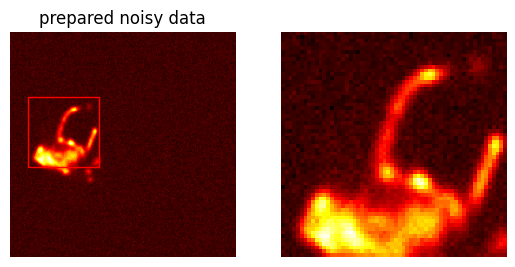

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gaussian_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

# 1. Create Nb2NbDataset with random neighbor subsampler

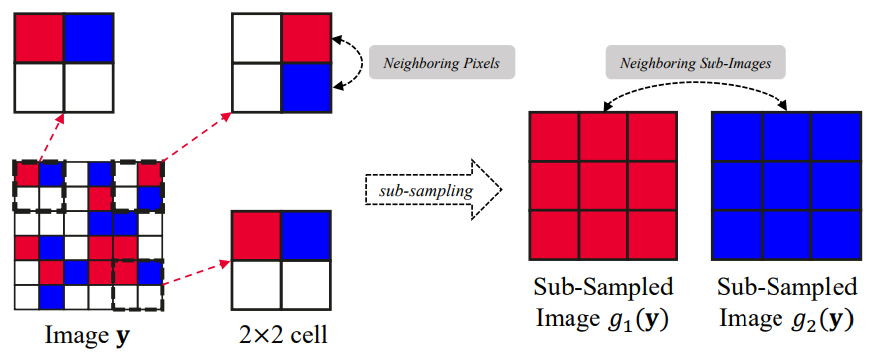

In [3]:
## split ndarray data
train_data, val_data, test_data = split_data(noisy_data)

## add channel dim
train_tensor = torch.tensor(train_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
val_tensor = torch.tensor(val_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
test_tensor = torch.tensor(test_data[..., np.newaxis, :, :, :], dtype=torch.float32) 

print(f"train_tensor:\n {train_tensor.dtype}; shape:{train_tensor.shape}; range:({torch.min(train_tensor)},{torch.max(train_tensor)}); mean:{torch.mean(train_tensor)}; std:{torch.std(train_tensor)}")
print(f"val_tensor:\n {val_tensor.dtype}; shape:{val_tensor.shape}; range:({torch.min(val_tensor)},{torch.max(val_tensor)}); mean:{torch.mean(val_tensor)}; std:{torch.std(val_tensor)}")
print(f"test_tensor:\n {test_tensor.dtype}; shape:{test_tensor.shape}; range:({torch.min(test_tensor)},{torch.max(test_tensor)}); mean:{torch.mean(test_tensor)}; std:{torch.std(test_tensor)}")


# create Nb2Nb dataset 
train_dataset = Nb2NbDataset(train_tensor, k=2)
val_dataset = Nb2NbDataset(val_tensor, k=2)
test_dataset = Nb2NbDataset(test_tensor, k=2)

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")


# create dataloader
batch_size = 16
num_workers = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_tensor:
 torch.float32; shape:torch.Size([8, 24, 1, 71, 192, 192]); range:(0.0,0.9951097369194031); mean:0.4927648901939392; std:0.0223699938505888
val_tensor:
 torch.float32; shape:torch.Size([2, 24, 1, 71, 192, 192]); range:(0.00923091173171997,0.9932047724723816); mean:0.4927580952644348; std:0.022349879145622253
test_tensor:
 torch.float32; shape:torch.Size([1, 24, 1, 71, 192, 192]); range:(0.002076786942780018,1.0); mean:0.4927551746368408; std:0.02243882790207863
train_dataset: 13248
val_dataset: 3312
test_dataset: 1656


Batch 1
top_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9770267009735107,0.021602991968393326); mean:0.4930545389652252; std:0.02144586853682995
top_g1: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9686276316642761,0.08105729520320892); mean:0.4930447041988373; std:0.02146904729306698
top_g2: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9643046259880066,0.021602991968393326); mean:0.49306005239486694; std:0.021513931453227997
middle_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.97884601354599,0.02375495247542858); mean:0.4930046796798706; std:0.021420365199446678
middle_g1: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9700874090194702,0.17406243085861206); mean:0.49300968647003174; std:0.021414730697870255
middle_g2: torch.float32 torch.Size([16, 1, 96, 96]) range:(0.9696994423866272,0.11025745421648026); mean:0.49298423528671265; std:0.021414194256067276
bottom_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9611748456954956,

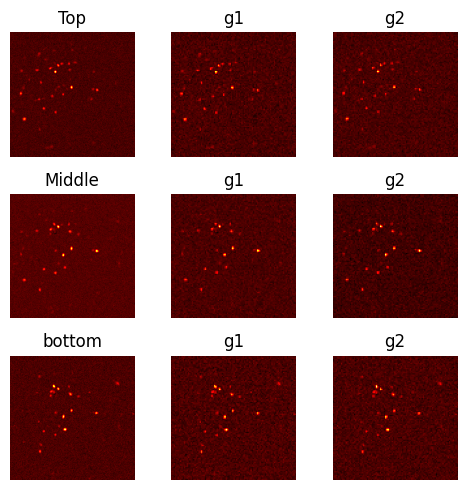

In [4]:
# example batch plot
num_batches_to_display = 1  # for example, show 3 batches

# Iterate through the DataLoader
for batch_idx, ((top_slice, top_g1, top_g2), (middle_slice, middle_g1, middle_g2), (bottom_slice, bottom_g1, bottom_g2)) in enumerate(train_loader):
    
    # Print data details(return (top_slice, top_g1, top_g2), (middle_slice, middle_g1, middle_g2), (bottom_slice, bottom_g1, bottom_g2))
    print(f"Batch {batch_idx + 1}")
    print(f"top_slice: {top_slice.dtype} {top_slice.shape} range:({torch.max(top_slice)},{torch.min(top_slice)}); mean:{torch.mean(top_slice)}; std:{torch.std(top_slice)}")
    print(f"top_g1: {top_g1.dtype} {top_g1.shape} range:({torch.max(top_g1)},{torch.min(top_g1)}); mean:{torch.mean(top_g1)}; std:{torch.std(top_g1)}")
    print(f"top_g2: {top_g2.dtype} {top_g2.shape} range:({torch.max(top_g2)},{torch.min(top_g2)}); mean:{torch.mean(top_g2)}; std:{torch.std(top_g2)}")
    print(f"middle_slice: {middle_slice.dtype} {middle_slice.shape} range:({torch.max(middle_slice)},{torch.min(middle_slice)}); mean:{torch.mean(middle_slice)}; std:{torch.std(middle_slice)}")
    print(f"middle_g1: {middle_g1.dtype} {middle_g1.shape} range:({torch.max(middle_g1)},{torch.min(middle_g1)}); mean:{torch.mean(middle_g1)}; std:{torch.std(middle_g1)}")
    print(f"middle_g2: {middle_g2.dtype} {middle_g2.shape} range:({torch.max(middle_g2)},{torch.min(middle_g2)}); mean:{torch.mean(middle_g2)}; std:{torch.std(middle_g2)}")
    print(f"bottom_slice: {bottom_slice.dtype} {bottom_slice.shape} range:({torch.max(bottom_slice)},{torch.min(bottom_slice)}); mean:{torch.mean(bottom_slice)}; std:{torch.std(bottom_slice)}")
    print(f"bottom_g1: {bottom_g1.dtype} {bottom_g1.shape} range:({torch.max(bottom_g1)},{torch.min(bottom_g1)}); mean:{torch.mean(bottom_g1)}; std:{torch.std(bottom_g1)}")
    print(f"bottom_g2: {bottom_g2.dtype} {bottom_g2.shape} range:({torch.max(bottom_g2)},{torch.min(bottom_g2)}); mean:{torch.mean(bottom_g2)}; std:{torch.std(bottom_g2)}")
    
    # select the show baych index
    idx = -1

    fig, axes = plt.subplots(3, 3, figsize=(5, 5))

    # 对于每个子图，使用imshow显示图像，并注意要将NumPy数组转换为标准的NumPy数组形状
    axes[0, 0].imshow(top_slice[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[0, 0].set_title('Top')
    axes[0, 1].imshow(top_g1[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[0, 1].set_title('g1')
    axes[0, 2].imshow(top_g2[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[0, 2].set_title('g2')

    axes[1, 0].imshow(middle_slice[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[1, 0].set_title('Middle')
    axes[1, 1].imshow(middle_g1[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[1, 1].set_title('g1')
    axes[1, 2].imshow(middle_g2[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[1, 2].set_title('g2')

    axes[2, 0].imshow(bottom_slice[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[2, 0].set_title('bottom')
    axes[2, 1].imshow(bottom_g1[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[2, 1].set_title('g1')
    axes[2, 2].imshow(bottom_g2[idx].permute(2, 1, 0).numpy(), cmap='hot')
    axes[2, 2].set_title('g2')

    for ax in axes.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Break loop after displaying desired number of batches
    if batch_idx + 1 == num_batches_to_display:
        break

# 2. Define loss function with reguralization term

In [5]:
def random_neighbor_subsample(tensor, k=2):
    """
    Perform random neighbor sub-sampling on a batch tensor.

    This function randomly selects two neighboring cells from kxk patches
    in the given tensor.

    Args:
        tensor (torch.Tensor): Input tensor of shape [batch, channels, height, width].
        k (int, optional): The size of the cell for sub-sampling. Defaults to 2.

    Returns:
        tuple: Two sub-sampled tensors (g1, g2) each of shape [batch, channels, height//k, width//k].
    """
    B, C, H, W = tensor.shape
    unfolded = tensor.unfold(2, k, k).unfold(3, k, k)
    unfolded = unfolded.contiguous().view(B, C, H//k, W//k, k*k)
    
    idx1, idx2 = torch.randperm(k*k)[:2].to(tensor.device)
    
    g1 = unfolded[..., idx1].squeeze(-1)
    g2 = unfolded[..., idx2].squeeze(-1)
    
    return g1, g2



def compute_gradients(img):
    """
    Compute the gradient of the input image using Sobel operator.

    Args:
        img (torch.Tensor): The input image tensor with shape (B, C, H, W).

    Returns:
        torch.Tensor: The gradient magnitude of the image with shape (B, C, H, W).
    """
    # Define Sobel operator kernels
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(img.device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(img.device)

    # Ensure the image has a batch dimension
    if img.ndim == 3:
        img = img.unsqueeze(0)  # Add a batch dimension
    if img.ndim == 4 and img.shape[1] != 1:
        img = img.unsqueeze(1)  # Add a channel dimension if needed

    # Apply Sobel operator to compute gradients in x and y direction
    grad_x = F.conv2d(img, sobel_x, padding=1)
    grad_y = F.conv2d(img, sobel_y, padding=1)

    # Combine the gradients to get the gradient magnitude
    grad = torch.sqrt(grad_x**2 + grad_y**2)
    return grad

def gradient_preservation_loss(input_upper_slice, input_middle_slice, input_lower_slice, output_slice):
    """
    Calculate the gradient preservation loss between the input middle slice and the output slice, and also
    between the output slice and the adjacent upper and lower slices.

    Args:
        input_upper_slice (torch.Tensor): The input upper slice tensor with shape (B, C, H, W).
        input_middle_slice (torch.Tensor): The input middle slice tensor with shape (B, C, H, W).
        input_lower_slice (torch.Tensor): The input lower slice tensor with shape (B, C, H, W).
        output_slice (torch.Tensor): The output tensor containing the denoised middle slice with shape (B, C, H, W).

    Returns:
        torch.Tensor: The computed loss value.
    """
    # Compute gradients for all the slices
    grad_input_middle = compute_gradients(input_middle_slice)
    grad_output = compute_gradients(output_slice)
    grad_input_upper = compute_gradients(input_upper_slice)
    grad_input_lower = compute_gradients(input_lower_slice)

    # Calculate gradient difference loss for the middle slice
    grad_loss_middle = F.mse_loss(grad_output, grad_input_middle)

    # Calculate gradient difference loss for the adjacent upper and lower slices
    grad_loss_upper = F.mse_loss(grad_output, grad_input_upper)
    grad_loss_lower = F.mse_loss(grad_output, grad_input_lower)

    # Combine losses from middle and adjacent slices
    total_loss = grad_loss_middle + grad_loss_upper + grad_loss_lower
    return total_loss


def joint_loss_function(model, device, criterion, slices, gamma=1.0, beta=1.0):
    """
    Compute the joint loss for Neighbor2Neighbor with regularization.
    
    Args:
        model (nn.Module): The neural network model.
        device (torch.device): The device (CPU or GPU) where the tensors reside.
        criterion (nn.Module): The loss function for reconstruction.
        slices (tuple): A tuple containing the input slices and their corresponding g1, g2 samples.
        gamma (float): Weight for the regularization loss term.
        beta (float): Weight for the gradient preservation loss term.

    Returns:
        torch.Tensor: Computed joint loss.
    """
    ((top_slice, top_g1, top_g2), (middle_slice, middle_g1, middle_g2), (bottom_slice, bottom_g1, bottom_g2)) = slices

    # Move all slices to the device
    top_slice, top_g1, top_g2 = top_slice.to(device), top_g1.to(device), top_g2.to(device)
    middle_slice, middle_g1, middle_g2 = middle_slice.to(device), middle_g1.to(device), middle_g2.to(device)
    bottom_slice, bottom_g1, bottom_g2 = bottom_slice.to(device), bottom_g1.to(device), bottom_g2.to(device)

    # Compute the model output for g1 slices
    middle_g1_output = model(top_g1, middle_g1, bottom_g1).to(device)

    # Compute reconstruction loss
    reconstruction_loss = criterion(middle_g1_output, middle_g2)

    # Compute regularization loss without gradients
    with torch.no_grad():
        no_grad_middle_output = model(top_slice, middle_slice, bottom_slice).to(device)
        no_grad_middle_output_g1, no_grad_middle_output_g2 = random_neighbor_subsample(no_grad_middle_output)

    regularization_loss = (middle_g1_output - middle_g2 - (no_grad_middle_output_g1 - no_grad_middle_output_g2)).norm(p=2, dim=(1,2,3)).mean()

    # Compute gradient preservation loss
    grad_pres_loss = gradient_preservation_loss(top_slice, middle_slice, bottom_slice, no_grad_middle_output)

    print(f"recon: {reconstruction_loss}, regular:{regularization_loss}. grad_pres:{grad_pres_loss}")
    
    # Combine all loss terms
    joint_loss = reconstruction_loss + gamma * regularization_loss + beta * grad_pres_loss
    
    return joint_loss


# 3. Define model and other training modules

In [8]:
model = UNet2_5D(in_channels=3, out_channels=1)
model = model.to(device)

print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, [(1, 192, 192), (1, 192, 192), (1, 192, 192)])

The number of parameters of the network is:  138372097
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           1,792
       BatchNorm2d-2         [-1, 64, 192, 192]             128
         LeakyReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,928
       BatchNorm2d-5         [-1, 64, 192, 192]             128
            Conv2d-6         [-1, 64, 192, 192]             256
         LeakyReLU-7         [-1, 64, 192, 192]               0
         UNetBlock-8         [-1, 64, 192, 192]               0
         MaxPool2d-9           [-1, 64, 96, 96]               0
           Conv2d-10          [-1, 128, 96, 96]          73,856
      BatchNorm2d-11          [-1, 128, 96, 96]             256
        LeakyReLU-12          [-1, 128, 96, 96]               0
           Conv2d-13          [-1, 128, 96, 96] 

In [12]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    for (top_slice, top_g1, top_g2), (middle_slice, middle_g1, middle_g2), (bottom_slice, bottom_g1, bottom_g2) in pbar:
        
        top_slice, top_g1, top_g2 = top_slice.to(device), top_g1.to(device), top_g2.to(device)
        middle_slice, middle_g1, middle_g2 = middle_slice.to(device), middle_g1.to(device), middle_g2.to(device)
        bottom_slice, bottom_g1, bottom_g2 = bottom_slice.to(device), bottom_g1.to(device), bottom_g2.to(device)
            
        
        
    #     slices_g1 = 
        
    #     # Forward
    #     g1_output = model(slices_g1)
        
    #     # Zero the gradient buffers
    #     optimizer.zero_grad()
        
    #     loss = joint_loss_function(model, device, criterion, g1_output, g2, slice_2d)
        
    #     # Backward
    #     loss.backward()
        
    #     # Update weights
    #     optimizer.step()
        
    #     total_loss += loss.item()
    #     pbar.set_postfix({"batch_loss": loss.item()})
    
    # scheduler.step()
    # avg_loss = total_loss / len(train_loader)
    # return avg_loss



def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0 
    pbar = tqdm(val_loader, desc="Validating", dynamic_ncols=True)
    with torch.no_grad():
        for slice_2d, g1, g2 in pbar:
            
            slice_2d, g1, g2 = slice_2d.to(device), g1.to(device), g2.to(device)
            
            g1_output = model(g1)
            
            loss = joint_loss_function(model, device, criterion, g1_output, g2, slice_2d)
            
            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss



def test(model, test_loader, device, dataset):
    model.eval()
    p, t, d = dataset.p, dataset.t, dataset.d
    # Note: d represents number of continuous slices after subtracting 2
    original_shape = (p, t, dataset.data_tensor.shape[2], d+2, dataset.data_tensor.shape[4], dataset.data_tensor.shape[5])

    preds = torch.zeros(original_shape).to(device)
    targets = torch.zeros(original_shape).to(device)

    pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
    with torch.no_grad():
        for idx, (slice_2d, g1, g2) in enumerate(pbar):
            
            slice_2d = slice_2d.to(device)
            
            batch_preds = model(slice_2d)

            for b_idx, pred in enumerate(batch_preds):
                pred = pred.squeeze(0) # [channels, height, width]
                true_idx = idx*test_loader.batch_size + b_idx
                patience_idx = true_idx // (t * d)
                time_idx = (true_idx % (t * d)) // d
                depth_idx = true_idx % d + 1
                
                preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
                targets[patience_idx, time_idx, :, depth_idx, :, :] = slice_2d[b_idx]

    return preds.cpu(), targets.cpu()


@timer_decorator
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5, save_path='path/to/your/directory'):
    best_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = -1
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {current_lr:.8e}")

        # Save the model with the best validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # 1-based counting for epoch
            best_save_path = os.path.join(save_path, f'best_model.pth')
            torch.save(best_model_wts, best_save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement epoch:{epoch - patience}.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# define loss, optimizer, lr_scheduler

criterion = nn.L1Loss()
#criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 4. Process training

In [13]:
trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=10, save_path="./check_points")

Training:   0%|          | 0/828 [00:00<?, ?it/s]

torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 96]) torch.Size([16, 1, 96, 96])
torch.Size([16, 1, 192, 192]) torch.Size([16, 1, 96, 9

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'to'

# 5. Evaluation

In [ ]:
# load best model
model.load_state_dict(torch.load('check_points/best_model.pth'))

In [ ]:
preds, targets = test(model, test_loader, device, test_dataset)

In [ ]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


# example plot
data_range_true = np.max(true_data[11, 38]) - np.min(true_data[11, 38])
data_range_denoised = np.max(denoised_data[11, 38]) - np.min(denoised_data[11, 38])
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data[11, 38], true_data[11, 38], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(denoised_data[11, 38], title='denoised')
display_image_in_detail(true_data[11, 38], title='true')

In [ ]:
data_range_true = np.max(true_data) - np.min(true_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, true_data, data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

# Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_image_in_detail(restored_data[11, 38], title="restored")

In [ ]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/Nb2Nb_extend/PT_20p 150_120 OSEM_gaussian_0.50'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)